## Import & definitions

In [3]:
import os
import hashlib
import sys
from pathlib import Path
import re
import random
import time
import math
import itertools
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import randint
from scipy.stats import uniform
import scipy.stats as stats
from scipy.stats.mstats import mquantiles
import xgboost as xgb
# from helpers.ocean_helpers import save_list
'''import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import L1L2'''
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
#sns.set_theme("notebook")
#mpl.style.use('seaborn-v0_8-ticks')
# definitions
DT_PAST = 5 # 5 min
PAST_HISTORY = int(6*60 / DT_PAST) #  6 hours in 5mins units : used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15 : 1h15
STEP = 1
BATCH_SIZE = 256 #128 #32
TRAIN_SPLIT_RATIO = 0.9 #0.8 #0.9891 # 1-(60/5*24)/50977
TARGET_NAME = "Close_ETH"
MODE_TRAIN_AE = True 
'''
#LIST_SEEDS = [1,2,3,4,5]
LIST_SEEDS = [1]
MODE_AUTO_SELECT = 0 #1 #   #0 # 0: False, 1: True, 2: from disk
MODE_TRAIN_PREDICTOR = True # False

EPOCHS_AE = 1#30
PATIENCE_AE = 0#10
LIST_UNITS_ENC_AE = [64]
LIST_UNITS_AE = [16]
LIST_DROPOUT_AE = [0.2]

EPOCHS_PRED = 100#30
PATIENCE_PRED = 0#10
LIST_UNITS_PRED = [128]
LIST_DROPOUT_PRED = [0.2]

MODE_TRAIN_LSTM = False
'''
# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_features_05m.csv")

path_save_pred_vals = os.path.join(path_data, "pred_vals.csv")
path_save_auto_select = os.path.join(path_data, "list_auto_select.csv")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
path_save_df_feat_std = os.path.join(path_data, "df_features_05m_std.csv")
path_X_train = os.path.join(path_data, 'X_train.dat')
path_X_train_sca = os.path.join(path_data, 'X_train_sca.dat')
path_df_prob_comb = os.path.join(path_data, 'df_prob_comb.csv')
path_df_prob_comb_2 = os.path.join(path_data, 'df_prob_comb_2.csv')
path_df_prob_comb_1b = os.path.join(path_data, 'df_prob_comb_1b.csv')
path_arr_corr_matrix_targets = os.path.join(
    path_data, 'arr_corr_matrix_targets.npy'
)
path_pca = os.path.join(path_data,"pca_model.pkl")
path_hash_pca = os.path.join(path_data, 'pca_hash.txt')

'''
path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")
'''

'\npath_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")\npath_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")\npath_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")\npath_mdl_predict_autoenc_lstm  =  os.path.join(\n    path_data, "mdl_predict_autoenc_lstm")\n'

## Load 

In [4]:
# LOAD
df_prob_comb_high_event = pd.read_pickle(os.path.join(path_data, 'df_prob_comb_high_event.pkl'))
global_event_by_day = pd.read_pickle(os.path.join(path_data, 'global_event_by_day.pkl'))
df_combined_condition = pd.read_pickle(os.path.join(path_data, 'df_combined_condition.pkl'))
df_prob_comb_high_event_test = pd.read_pickle(os.path.join(path_data, 'df_prob_comb_high_event_test.pkl'))
global_event_by_day_test = pd.read_pickle(os.path.join(path_data, 'global_event_by_day_test.pkl'))
df_combined_condition_test = pd.read_pickle(os.path.join(path_data, 'df_combined_condition_test.pkl'))

df_targets = pd.read_pickle(os.path.join(path_data, "df_targets.pkl"))
df_targets_test = pd.read_pickle(os.path.join(path_data, "df_targets_test.pkl"))

with open(os.path.join(path_data, "list_df.pkl"), "rb") as f:
    list_df = pickle.load(f)

with open(os.path.join(path_data, "list_df_test.pkl"), "rb") as f:
    list_df_test = pickle.load(f)

In [5]:
# X train : df_combined_condition train
# X test: df_combined_condition_test

# Y train : high trade or not
y_comb = (list_df[0]["target_cat"] == "high")
# Y test 
y_comb_test = df_targets_test["target_cat"] == "high"

## Functions

In [6]:
# --- Define the new, simplified custom metric ---

def fun_nb_trade_fixed_window(y_true, y_pred):
    """
    Custom XGBoost metric to count 30-minute windows with at least one trade signal.
    Assumes each prediction corresponds to a 5-minute interval.
    
    Args:
        y_pred (np.ndarray): The array of predictions (0s and 1s).
        y_true (DMatrix): The DMatrix object with the true labels. We don't use it
                          for this specific metric, but it's part of the function signature.
    """
    window_size = 6  # 30 minutes / 5 minutes per data point

    # Calculate the number of full, non-overlapping windows we can form
    num_windows = len(y_pred) // window_size
    
    # If there are no full windows, the trade count is 0
    if num_windows == 0:
        return 0.0
    
    if y_pred.sum() == 0:
        return 0.0
    # Truncate y_pred to the largest size that is a multiple of window_size
    trunc_len = num_windows * window_size
    y_pred_truncated = y_pred[:trunc_len]

    # Reshape the predictions into a 2D array where each row is a 30-min window
    # The '-1' tells numpy to automatically calculate the number of rows
    pred_windows = y_pred_truncated.reshape(-1, window_size)

    # Sum the predictions in each window (each row)
    sum_in_windows = pred_windows.sum(axis=1)

    # Count how many windows have a sum of 1 or more (at least one trade signal)
    # The result of the boolean comparison is an array of True/False,
    # and .sum() counts the number of True values.
    total_trades = (sum_in_windows >= 1).sum()
    #precision_score(y_true, y_pred)
    # XGBoost custom metrics must return a list of (name, value) tuples
    return precision_score(y_true, y_pred) + 10*float(total_trades)


In [7]:
def fun_trade(total_trades, winrate, risk=250, R=1.23 ):
    return total_trades * risk * (winrate * (1 + R) - 1)

def fun_arr_trade(arr_trade, arr_winrate, risk=250, R=1.23):
    return arr_trade * risk * (arr_winrate * (1 + R) - 1)

def fun_trades_gain(y_true, y_pred):
    """
    Custom XGBoost metric to count 30-minute windows with at least one trade signal.
    Assumes each prediction corresponds to a 5-minute interval.
    
    Args:
        y_pred (np.ndarray): The array of predictions (0s and 1s).
        y_true (DMatrix): The DMatrix object with the true labels. We don't use it
                          for this specific metric, but it's part of the function signature.
    """
    risk = 250
    R = 1.23
    window_size = 6  # 30 minutes / 5 minutes per data point

    # Calculate the number of full, non-overlapping windows we can form
    num_windows = len(y_pred) // window_size
    
    # If there are no full windows, the trade count is 0
    if num_windows == 0:
        return 0.0
    if y_pred.sum() == 0:
        return 0.0
    
    # Truncate y_pred to the largest size that is a multiple of window_size
    trunc_len = num_windows * window_size
    y_pred_truncated = y_pred[:trunc_len]

    # Reshape the predictions into a 2D array where each row is a 30-min window
    # The '-1' tells numpy to automatically calculate the number of rows
    pred_windows = y_pred_truncated.reshape(-1, window_size)

    # Sum the predictions in each window (each row)
    sum_in_windows = pred_windows.sum(axis=1)

    # Count how many windows have a sum of 1 or more (at least one trade signal)
    # The result of the boolean comparison is an array of True/False,
    # and .sum() counts the number of True values.
    total_trades = (sum_in_windows >= 1).sum()
    #precision_score(y_true, y_pred)
    winrate = precision_score(y_true, y_pred)
    #total_gain = total_trades * risk * (winrate * (1 + R) - 1)
    total_gain = fun_trade(total_trades, winrate, risk, R )
    # XGBoost custom metrics must return a list of (name, value) tuples
    return total_gain #precision_score(y_true, y_pred) + 10*float(total_trades)


In [8]:
def fun_plot_trades_gain(arr_eval, arr_eval_train, title_str="XBGBoost model performance : total gain"):
    fig = make_subplots(
        rows=2, 
        cols=1, 
        shared_xaxes=True, 
        vertical_spacing=0.03
    )

    fig.add_trace(
        go.Scatter(y=arr_eval["fun_trades_gain"], name="total_gain test"),
        row=1,
        col=1,
    )
    fig.add_trace(
        go.Scatter(y=arr_eval_train["fun_trades_gain"], name="total_gain train"),
        row=1,
        col=1,
    )
    fig.update_layout(
        height=600,
        template="plotly_white",
        title=title_str,
        hovermode='x unified'
    )
    fig.update_xaxes(
        showspikes=True, 
        spikemode='across', 
        spikesnap='cursor',
        spikethickness=1,
        spikedash='dot'
    )

    # Optional: Add y-axis spikes for more context
    fig.update_yaxes(showspikes=True, spikedash='dot')

    fig.show()

In [9]:
def fun_decoded_nb_trade_fixed_window(arr_in):
    # arr_in = np.array(precision_score(y_true, y_pred) + 10*float(total_trades))
    return np.int64(arr_in/10), arr_in%10


In [10]:
# from CV : objective="binary:hinge", scoring="precision", min_resources=500,
#   colsample_bytree: 0.4145
#   learning_rate: 0.5959
#   max_depth: 2
#   reg_alpha: 0.0718
#   reg_lambda: 0.6826
#   subsample: 0.4177
best_params_= {}
best_params_["colsample_bytree"] = 0.4145
best_params_["learning_rate"] = 0.5959
best_params_["max_depth"] = 2
best_params_["reg_alpha"] = 0.0718
best_params_["reg_lambda"] = 0.6826
best_params_["subsample"] = 0.4177


## XGBoost

### Search n estimators to converge

Model trained.
Accuracy on training data: 0.75443345712709
Accuracy on test data: 0.720222072678331
For Model XGBoost: 
precision TRAIN: 0.447
% possible trades : 0.11
nb trade per day : 0.31
precision TEST: 0.450
% possible trades : 0.13
nb trade per day : 0.39


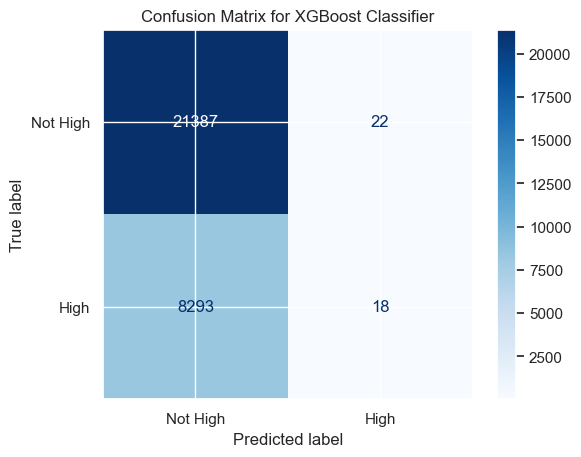

In [11]:
# n 100 : 14.875
xgb_mdl = xgb.XGBClassifier(
    verbosity=0,
    objective="binary:hinge",
    random_state=42,
    n_jobs=-1,
    #use_label_encoder=False, # Recommended to avoid a future warning
    eval_metric=fun_nb_trade_fixed_window, #fun_trades_gain, #[fun_nb_trade_fixed_window, precision_score], #, # A common metric for binary classification
    max_depth=best_params_["max_depth"],
    learning_rate=best_params_["learning_rate"],
    subsample=best_params_["subsample"],
    colsample_bytree=best_params_["colsample_bytree"],
    reg_alpha=best_params_["reg_alpha"],
    reg_lambda=best_params_["reg_lambda"],
    #scale_pos_weight=1.5,  # ajuster si classes déséquilibrées
    n_estimators=100,#400+59+1,
)
xgb_mdl.fit(
    df_combined_condition, 
    y_comb, 
    eval_set=[(df_combined_condition_test, y_comb_test), (df_combined_condition, y_comb)],
    verbose=0,
)
#xgb_mdl.fit(df_combined_condition, y_comb)
print("Model trained.")
print("Accuracy on training data:", xgb_mdl.score(df_combined_condition, y_comb))
print("Accuracy on test data:", xgb_mdl.score(df_combined_condition_test, y_comb_test))
arr_xgb_pred_train = xgb_mdl.predict(df_combined_condition)
arr_xgb_pred = xgb_mdl.predict(df_combined_condition_test)
cm = confusion_matrix(y_comb_test, arr_xgb_pred, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost Classifier")

print("For Model XGBoost: ")
print(f"precision TRAIN: {precision_score(y_comb, arr_xgb_pred_train):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred_train) / arr_xgb_pred_train.shape[0]:.2f}")
print(f"nb trade per day : {288*arr_xgb_pred_train.sum() / arr_xgb_pred_train.shape[0]:.2f}")
print(f"precision TEST: {precision_score(y_comb_test, arr_xgb_pred):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred) / arr_xgb_pred.shape[0]:.2f}")
# per day
print(f"nb trade per day : {288*arr_xgb_pred.sum() / arr_xgb_pred.shape[0]:.2f}")
plt.show()

In [12]:
fun_nb_trade_fixed_window(y_comb_test, arr_xgb_pred)

170.45

In [13]:
nb_trade, winrate = fun_decoded_nb_trade_fixed_window(fun_nb_trade_fixed_window(y_comb_test, arr_xgb_pred))

In [14]:
fun_trades_gain(y_comb_test, arr_xgb_pred)

np.float64(14.875000000000249)

In [15]:
fun_trade(nb_trade, winrate, risk=250, R=1.23)

np.float64(14.874999999892669)

In [16]:
def fun_winrate(nb_trade, gain=333, risk=250, R=1.23):
    return (gain / (nb_trade * risk)+1) /(1 + R)

def fun_arr_winrate(arr_nb_trade, gain=333, risk=250, R=1.23):
    return (gain / (arr_nb_trade * risk)+1) /(1 + R)


In [17]:
fun_winrate(nb_trade=17, gain=14.875, risk=250, R=1.23)

0.45

In [18]:
fun_arr_winrate(np.array([17,100]), gain=333, risk=250, R=1.23)

array([0.48356634, 0.45440359])

In [19]:
arr_eval = xgb_mdl.evals_result_["validation_0"]
arr_eval_train = xgb_mdl.evals_result_["validation_1"]

In [20]:
arr_eval_nb_trade, arr_eval_precision = fun_decoded_nb_trade_fixed_window(np.array(arr_eval["fun_nb_trade_fixed_window"]))

In [21]:
arr_eval_nb_trade_train, arr_eval_precision_train = fun_decoded_nb_trade_fixed_window(
    np.array(arr_eval_train["fun_nb_trade_fixed_window"])
)

In [22]:
r_period_test = 1/ (y_comb_test.shape[0]/(30*288))
r_period_train = 1/ (y_comb.shape[0]/(30*288))

In [23]:
arr_eval_gain = fun_arr_trade(arr_eval_nb_trade, arr_eval_precision, risk=250, R=1.23)

In [24]:
arr_eval_gain_train = fun_arr_trade(arr_eval_nb_trade_train, arr_eval_precision_train, risk=250, R=1.23)

In [25]:
df = pd.DataFrame({
    'trades_train': arr_eval_nb_trade_train*r_period_train,
    'precision_train': arr_eval_precision_train,
    'gain_train': arr_eval_gain_train*r_period_train,
    'trades_test': arr_eval_nb_trade*r_period_test,
    'precision_test': arr_eval_precision,
    'gain_test': arr_eval_gain*r_period_test,
})
# The index is automatically available, but we can add it as a column if we want to name it.
df['run_index'] = df.index

df

trades_train  precision_train  gain_train  trades_test  precision_test  \
0       0.000000         0.000000   -0.000000     0.000000        0.000000   
1       0.000000         0.000000   -0.000000     0.000000        0.000000   
2       0.000000         0.000000   -0.000000     0.000000        0.000000   
3       0.000000         0.000000   -0.000000     0.000000        0.000000   
4       0.515459         0.545455   27.881793     0.000000        0.000000   
..           ...              ...         ...          ...             ...   
95      6.378809         0.454039   19.944893     5.814266        0.439024   
96      5.315674         0.459459   32.682851     4.360700        0.400000   
97     10.921294         0.431373 -103.856619    16.279946        0.355140   
98      7.377511         0.429561  -77.609519    10.174966        0.345679   
99      5.283458         0.446735   -4.994123     4.942127        0.450000   

     gain_test  run_index  
0    -0.000000          0  
1    -0.000000          1  
2    -0.000000          2  
3    -0.000000          3  
4    -0.000000          4  
..         ...        ...  
95  -30.490711         95  
96 -117.738896         96  
97 -846.711046         97  
98 -582.862340         98  
99    4.324361         99  

[100 rows x 7 columns]

In [26]:
gain_period_min = 333
gain_period_min

333

In [27]:
gain_period_bingo = 1000
gain_period_bingo

1000

In [28]:
arr_nb_trade_winrate_train = np.linspace(0.5, max(df["trades_train"]), 100)
arr_winrate_min_train = fun_arr_winrate(arr_nb_trade_winrate_train, gain=gain_period_min, risk=250, R=1.23)
arr_winrate_bingo_train = fun_arr_winrate(arr_nb_trade_winrate_train, gain=gain_period_bingo, risk=250, R=1.23)

In [29]:
df[df["gain_test"] == df["gain_test"].max()]

trades_train  precision_train  gain_train  trades_test  precision_test  \
63     15.818157         0.367604 -712.778353    22.094213        0.512048   

     gain_test  run_index  
63  783.610137         63

In [30]:
df.sort_values(by=['trades_train'], ascending=False)

trades_train  precision_train  gain_train  trades_test  precision_test  \
55     16.494698         0.379163 -636.969599    19.187079        0.381579   
63     15.818157         0.367604 -712.778353    22.094213        0.512048   
91     13.949617         0.400480 -372.906753    21.512786        0.470968   
94     13.240861         0.409898 -284.438386    21.512786        0.463087   
77     12.789834         0.398230 -357.946206    19.477793        0.452055   
..           ...              ...         ...          ...             ...   
3       0.000000         0.000000   -0.000000     0.000000        0.000000   
1       0.000000         0.000000   -0.000000     0.000000        0.000000   
5       0.000000         0.000000   -0.000000     0.000000        0.000000   
7       0.000000         0.000000   -0.000000     0.000000        0.000000   
0       0.000000         0.000000   -0.000000     0.000000        0.000000   

     gain_test  run_index  
55 -715.096837         55  
63  783.610137         63  
91  270.300842         91  
94  175.781028         94  
77   39.358045         77  
..         ...        ...  
3    -0.000000          3  
1    -0.000000          1  
5    -0.000000          5  
7    -0.000000          7  
0    -0.000000          0  

[100 rows x 7 columns]

In [31]:
# --- 3. Create the Plot with Custom Hover Data ---
# We now pass column names (as strings) to plotly.express.
fig = px.scatter(
    df,  # Pass the entire DataFrame as the first argument
    x='trades_test',
    y='precision_test',
    title="Evaluation Precision vs. Number of Trades",
    color_discrete_sequence=["#3CB620"],
    #hover_data=df[['run_index', 'gain_test', 'gain_train']],
)
# Customize the hover template for a cleaner look (Optional but recommended)
fig.update_traces(
    hovertemplate="Gain test: %{customdata[1]:.2f}<br>" +
                  "Number of Trades: %{x}<br>" +
                  "Precision: %{y:.3f}<br>" +
                  "Run Index: %{customdata[0]}" +
                  "<extra></extra>", # <extra></extra> hides the secondary box
    customdata=df[['run_index', 'gain_test']]
)

# add precision = f(nb_trade) to have a gain = 333/mth
fig.add_scatter(
    x=arr_nb_trade_winrate_train,
    y=arr_winrate_min_train,
    mode='lines',
    line=dict(color='red', width=2),
    line_dash="dash",
    name="333$/mth Precision",
    hovertemplate=f"Gain: {gain_period_min:.2f}<br>" +
                  "Number of Trades: %{x}<br>" +
                  "Precision: %{y:.4f}<br>" +
                  "<extra></extra>", # <extra></extra> hides the secondary box
)
# add precision = f(nb_trade) to have a gain = 1000/mth
fig.add_scatter(
    x=arr_nb_trade_winrate_train,
    y=arr_winrate_bingo_train,
    mode='lines',
    line=dict(color='blue', width=2),
    line_dash="dash",
    name="1000$/mth Precision",
    hovertemplate=f"Gain: {gain_period_bingo:.2f}<br>" +
                  "Number of Trades: %{x}<br>" +
                  "Precision: %{y:.4f}<br>" +
                  "<extra></extra>", # <extra></extra> hides the secondary box
)
# add train
fig.add_trace(
    go.Scatter(
        x=df["trades_train"],
        y=df["precision_train"],
        name="train",
        mode="markers",
        hovertemplate="Gain train: %{customdata[1]:.2f}<br>" +
                  "Number of Trades: %{x}<br>" +
                  "Precision: %{y:.4f}<br>" +
                  "Run Index: %{customdata[0]}" +
                  "<extra></extra>", # <extra></extra> hides the secondary box
        customdata=df[['run_index', 'gain_train']],
    )
)

fig.update_layout(
    xaxis_title="Number of Trades / mth",
    yaxis_title="Precision",
    font=dict(family="Arial, sans-serif", size=14),
     height=600,
)

fig.show()

In [32]:
fig = make_subplots(
    rows=2, 
    cols=1, 
    shared_xaxes=True, 
    vertical_spacing=0.03
)

fig.add_trace(
    go.Scatter(y=df["trades_train"], name="nb trade train"),
    row=1,
    col=1,
)
fig.add_trace(
    go.Scatter(y=df["trades_test"], name="nb trade test"),
    row=1,
    col=1,
)
fig.add_trace(
    go.Scatter(y=df["precision_train"], name="precision_train"),
    row=2,
    col=1,
)
fig.add_trace(
    go.Scatter(y=df["precision_test"], name="precision_test"),
    row=2,
    col=1,
)

fig.update_layout(
    height=600,
    template="plotly_white",
    title=f"XBGBoost model performance",
    hovermode='x unified'
)
fig.update_xaxes(
    showspikes=True, 
    spikemode='across', 
    spikesnap='cursor',
    spikethickness=1,
    spikedash='dot'
)

# Optional: Add y-axis spikes for more context
fig.update_yaxes(showspikes=True, spikedash='dot')

fig.show()

In [38]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

x = df.index  # *identique* pour toutes les traces

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.03)

fig.add_trace(go.Scatter(x=x, y=df["trades_train"], name="nb trade train",
                         hovertemplate="%{y}<extra></extra>", xaxis="x", yaxis="y"), row=1, col=1)
fig.add_trace(go.Scatter(x=x, y=df["trades_test"],  name="nb trade test",
                         hovertemplate="%{y}<extra></extra>", xaxis="x", yaxis="y2"), row=1, col=1)
fig.add_trace(go.Scatter(x=x, y=df["precision_train"], name="precision_train",
                         hovertemplate="%{y}<extra></extra>", xaxis="x", yaxis="y3"), row=2, col=1)
fig.add_trace(go.Scatter(x=x, y=df["precision_test"],  name="precision_test",
                         hovertemplate="%{y}<extra></extra>", xaxis="x", yaxis="y4"), row=2, col=1)

fig.update_layout(hovermode="x", hoversubplots="axis", height=600, template="plotly_white")
#fig.update_xaxes(showspikes=True, spikemode="across", spikesnap="cursor")
#fig.update_yaxes(showspikes=True)
fig.show()


In [44]:
import plotly.graph_objects as go

x = df.index  # identique pour toutes les traces

fig = go.Figure()

# Subplot du haut → yaxis et yaxis2
fig.add_trace(go.Scatter(
    x=x, y=df["trades_train"],
    name="nb trade train",
    hovertemplate="%{y}<extra></extra>",
    yaxis="y"
))
fig.add_trace(go.Scatter(
    x=x, y=df["trades_test"],
    name="nb trade test",
    hovertemplate="%{y}<extra></extra>",
    yaxis="y"
))

# Subplot du bas → yaxis3 (un seul axe pour ce sous-plot)
fig.add_trace(go.Scatter(
    x=x, y=df["precision_train"],
    name="precision_train",
    hovertemplate="%{y}<extra></extra>",
    yaxis="y2"
))
fig.add_trace(go.Scatter(
    x=x, y=df["precision_test"],
    name="precision_test",
    hovertemplate="%{y}<extra></extra>",
    yaxis="y2"
))

fig.update_layout(
    hovermode="x",
    hoversubplots="axis",
    height=600,
    template="plotly_white",

    # Un seul axe X commun pour tout
    xaxis=dict(
        domain=[0, 1],
        showspikes=True,
        spikemode="across",
        spikesnap="cursor",
        spikethickness=1,
    ),

    # Subplot du haut (traces train/test)
    yaxis=dict(
        domain=[0.55, 1.0],
        title="Trades",
        showspikes=True,
    ),

    # Subplot du bas (precision)
    yaxis2=dict(
        domain=[0.0, 0.45],
        title="Precision",
        anchor="x",
        showspikes=True,
    )
)

fig.show()


In [36]:
from plotly import data
df_ = data.stocks()

layout = dict(
    hoversubplots="axis",
    title=dict(text="Stock Price Changes"),
    hovermode="x",
    grid=dict(rows=3, columns=1),
)

data = [
    go.Scatter(x=df_["date"], y=df_["AAPL"], xaxis="x", yaxis="y", name="Apple"),
    go.Scatter(x=df_["date"], y=df_["GOOG"], xaxis="x", yaxis="y2", name="Google"),
    go.Scatter(x=df_["date"], y=df_["AMZN"], xaxis="x", yaxis="y3", name="Amazon"),
]

fig = go.Figure(data=data, layout=layout)

fig.show()

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no pred

Model trained.
Accuracy on training data: 0.7541239727355438
Accuracy on test data: 0.7177658142664872
For Model XGBoost: 
precision TRAIN: 0.486
% possible trades : 1.52
nb trade per day : 4.38
precision TEST: 0.368
% possible trades : 0.98
nb trade per day : 2.82


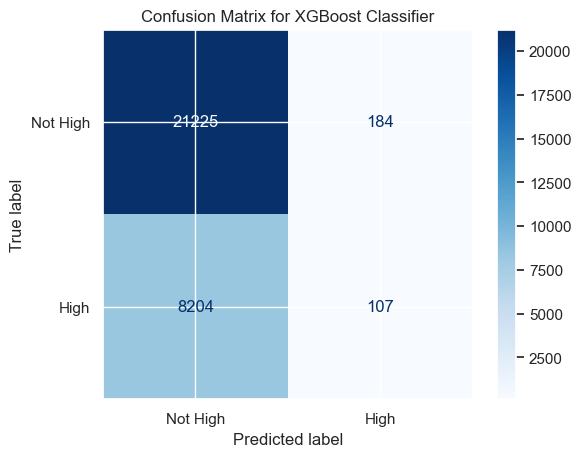

In [ ]:
xgb_mdl = xgb.XGBClassifier(
    verbosity=0,
    objective="binary:hinge",
    random_state=42,
    n_jobs=-1,
    #use_label_encoder=False, # Recommended to avoid a future warning
    eval_metric=fun_nb_trade_fixed_window, #[fun_nb_trade_fixed_window, precision_score], #, # A common metric for binary classification
    max_depth=best_params_["max_depth"],
    learning_rate=best_params_["learning_rate"],
    subsample=best_params_["subsample"],
    colsample_bytree=best_params_["colsample_bytree"],
    reg_alpha=best_params_["reg_alpha"],
    reg_lambda=best_params_["reg_lambda"],
    #scale_pos_weight=1.5,  # ajuster si classes déséquilibrées
    n_estimators=2000,#400+59+1,
)
xgb_mdl.fit(
    df_combined_condition, 
    y_comb, 
    eval_set=[(df_combined_condition_test, y_comb_test), (df_combined_condition, y_comb)],
    verbose=0,
)
#xgb_mdl.fit(df_combined_condition, y_comb)
print("Model trained.")
print("Accuracy on training data:", xgb_mdl.score(df_combined_condition, y_comb))
print("Accuracy on test data:", xgb_mdl.score(df_combined_condition_test, y_comb_test))
arr_xgb_pred_train = xgb_mdl.predict(df_combined_condition)
arr_xgb_pred = xgb_mdl.predict(df_combined_condition_test)
cm = confusion_matrix(y_comb_test, arr_xgb_pred, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost Classifier")

print("For Model XGBoost: ")
print(f"precision TRAIN: {precision_score(y_comb, arr_xgb_pred_train):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred_train) / arr_xgb_pred_train.shape[0]:.2f}")
print(f"nb trade per day : {288*arr_xgb_pred_train.sum() / arr_xgb_pred_train.shape[0]:.2f}")
print(f"precision TEST: {precision_score(y_comb_test, arr_xgb_pred):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred) / arr_xgb_pred.shape[0]:.2f}")
# per day
print(f"nb trade per day : {288*arr_xgb_pred.sum() / arr_xgb_pred.shape[0]:.2f}")
plt.show()

In [135]:
arr_eval_train = xgb_mdl.evals_result_
arr_eval_nb_trade_train, arr_eval_precision_train = fun_decoded_nb_trade_fixed_window(
    np.array(arr_eval_train["validation_1"]["fun_nb_trade_fixed_window"])
)

In [136]:
arr_eval = xgb_mdl.evals_result_
arr_eval_nb_trade, arr_eval_precision = fun_decoded_nb_trade_fixed_window(
    np.array(arr_eval["validation_0"]["fun_nb_trade_fixed_window"])
)

In [137]:
fig = make_subplots(
    rows=2, 
    cols=1, 
    shared_xaxes=True, 
    vertical_spacing=0.03
)

fig.add_trace(
    go.Scatter(y=arr_eval_nb_trade_train / (y_comb.shape[0]/288), name="nb trade_train"),
    row=1,
    col=1,
)
fig.add_trace(
    go.Scatter(y=arr_eval_nb_trade / (y_comb_test.shape[0]/288), name="nb trade"),
    row=1,
    col=1,
)
fig.add_trace(
    go.Scatter(y=arr_eval_precision_train, name="precision_train"),
    row=2,
    col=1,
)
fig.add_trace(
    go.Scatter(y=arr_eval_precision, name="precision"),
    row=2,
    col=1,
)

fig.update_layout(
    height=600,
    template="plotly_white",
    title=f"XBGBoost model performance on test set",
    hovermode='x unified'
)
fig.update_xaxes(
    showspikes=True, 
    spikemode='across', 
    spikesnap='cursor',
    spikethickness=1,
    spikedash='dot'
)

# Optional: Add y-axis spikes for more context
fig.update_yaxes(showspikes=True, spikedash='dot')

fig.show()

In [117]:
y_comb_test.shape[0]/288

103.19444444444444

In [140]:
# plot arr_eval_precision = f (arr_eval_nb_trade)
import plotly.express as px

# --- 2. Create the Plot ---
# We use plotly.express.scatter for a quick and clean plot.
# 'x' is your independent variable (f(x))
# 'y' is your dependent variable (y)
fig = px.scatter(
    x=arr_eval_nb_trade,
    y=arr_eval_precision,
    title="Evaluation Precision vs. Number of Trades",
    labels={
        "x": "Number of Trades (arr_eval_nb_trade)",
        "y": "Precision (arr_eval_precision)"
    },
    # This adds a trendline to better visualize the relationship
    trendline="ols" 
)
fig.add_trace(
    go.Scatter(
        x=arr_eval_nb_trade_train,
        y=arr_eval_precision_train,
        name="train",
        mode="markers"
    )
)
fig.add_hline(
    y=0.47, 
    line_dash="dash", 
    line_color="red",
    annotation_text="Minimum Acceptable Precision", 
    annotation_position="bottom right"
)
fig.add_vline(
    x=y_comb_test.shape[0]/288, 
    line_dash="dash", 
    line_color="red",
    annotation_text="Minimum Trading Volume", 
    annotation_position="top right"
)
# --- 3. Customize and Show the Plot ---
# Update the layout for a cleaner look
fig.update_layout(
    xaxis_title="Number of Trades",
    yaxis_title="Precision",
    font=dict(
        family="Arial, sans-serif",
        size=14
    ),
    height=600,
)

# Display the figure
fig.show()


In [146]:
50/103 * (0.55/0.47)

0.5680644494939063

In [ ]:
206/103 * (0.46/0.47)

1.9574468085106385

In [105]:
#arr_eval["validation_0"]["fun_nb_trade_fixed_window"]

In [ ]:
#plt.plot(arr_eval_nb_trade, label="nb trade")
#plt.plot(arr_eval_precision, label="precision")

In [103]:
#xgb_mdl.evals_result_["validation_0"]["fun_nb_trade_fixed_window"]

### CV eval average_precision

In [ ]:
# --- 3. Define the Base Model ---
# Note: 'n_estimators' is controlled by the search, so we don't set it here.
# 'early_stopping_rounds' is not used directly with HalvingRandomSearchCV.
xgb_mdl = xgb.XGBClassifier(
    objective="binary:hinge",
    random_state=42,
    #use_label_encoder=False, # Recommended to avoid a future warning
    eval_metric=fun_nb_trade_fixed_window, # A common metric for binary classification
    n_estimators=200,
)

# --- 4. Define the Hyperparameter Search Space ---
param_dist = {
    'max_depth': randint(1, 4),             # Search depths from 2 to 4
    'learning_rate': uniform(0.01, 1),   # Search from 0.05 up to 0.6
    'subsample': uniform(0.2, 0.9),         # Search between 0.4 and 0.9
    'colsample_bytree': uniform(0.1, 0.7),  # Search between 0.1 and 0.6
    'reg_alpha': uniform(0.0, 1),         # Search L1 regularization
    'reg_lambda': uniform(0.0, 1),        # Search L2 regularization
    'scale_pos_weight': uniform(1, 3),  # ajuster si classes déséquilibrées
}

tscv = TimeSeriesSplit(n_splits=5)

# --- 5. Set up and Run HalvingRandomSearchCV ---
halving_search = HalvingRandomSearchCV(
    n_jobs=-1,                # Use all available CPU cores
    random_state=42,
    verbose=1,                # Set to 1 or 2 to see the progress
    cv=tscv,
    factor=2,  # Keep the top 1/3 of candidates in each iteration
    estimator=xgb_mdl,
    param_distributions=param_dist,
    #max_resources=150,        # The maximum n_estimators to use for the final model
    min_resources=500,         # The initial n_samples to start with
    scoring='average_precision',       # Metric for evaluation, since hinge loss gives 0/1
)

print("Starting HalvingRandomSearchCV...")
# Fit the model to the data
halving_search.fit(df_combined_condition, y_comb)
print("\nSearch complete!")

# --- 6. Display the Results ---
print("\n--- Cross-Validation Results ---")
print(f"Best Score (Accuracy): {halving_search.best_score_:.4f}")
print("\nBest Parameters Found:")
# Using a loop for cleaner printing
for param, value in halving_search.best_params_.items():
    if isinstance(value, float):
        print(f"  {param}: {value:.4f}")
    else:
        print(f"  {param}: {value}")

# The best_estimator_ is a fully trained model on the entire dataset
# using the best parameters found.
best_model = halving_search.best_estimator_
print("\nBest model is now trained and ready to be used for predictions.")

Starting HalvingRandomSearchCV...
n_iterations: 10
n_required_iterations: 10
n_possible_iterations: 10
min_resources_: 500
max_resources_: 268188
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 536
n_resources: 500
Fitting 5 folds for each of 536 candidates, totalling 2680 fits


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:01:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:01:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:01:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:01:11] WARNING: /Users/runner/work/xgboost/xgboost/src

----------
iter: 1
n_candidates: 268
n_resources: 1000
Fitting 5 folds for each of 268 candidates, totalling 1340 fits


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:10:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:10:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:10:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:10:05] WARNING: /Users/runner/work/xgboost/xgboost/src

----------
iter: 2
n_candidates: 134
n_resources: 2000
Fitting 5 folds for each of 134 candidates, totalling 670 fits


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:15:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:15:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:15:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:15:34] WARNING: /Users/runner/work/xgboost/xgboost/src

----------
iter: 3
n_candidates: 67
n_resources: 4000
Fitting 5 folds for each of 67 candidates, totalling 335 fits


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:19:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:19:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:19:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:19:02] WARNING: /Users/runner/work/xgboost/xgboost/src

----------
iter: 4
n_candidates: 34
n_resources: 8000
Fitting 5 folds for each of 34 candidates, totalling 170 fits


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the test scores are non-finite: [0.25251233 0.24813385 0.2535547  ... 0.26648165 0.26981121 0.2617779 ]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the train scores are non-finite: [0.40651153 0.41090392 0.40798196 ... 0.36323059 0.35715398 0.35611253]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:21:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:21:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used

----------
iter: 5
n_candidates: 17
n_resources: 16000
Fitting 5 folds for each of 17 candidates, totalling 85 fits


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the test scores are non-finite: [0.25251233 0.24813385 0.2535547  ... 0.26589121 0.26995103 0.26509939]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the train scores are non-finite: [0.40651153 0.41090392 0.40798196 ... 0.33505009 0.31724392 0.33663458]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:23:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:23:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used

----------
iter: 6
n_candidates: 9
n_resources: 32000
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the test scores are non-finite: [0.25251233 0.24813385 0.2535547  ... 0.26555456 0.26342182 0.26115476]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the train scores are non-finite: [0.40651153 0.41090392 0.40798196 ... 0.28057335 0.28122264 0.33009578]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:25:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:25:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used

----------
iter: 7
n_candidates: 5
n_resources: 64000
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the test scores are non-finite: [0.25251233 0.24813385 0.2535547  ... 0.25985107 0.25897592 0.25809777]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the train scores are non-finite: [0.40651153 0.41090392 0.40798196 ... 0.29018649 0.25579167 0.25888367]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:27:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:27:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used

----------
iter: 8
n_candidates: 3
n_resources: 128000
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the test scores are non-finite: [0.25251233 0.24813385 0.2535547  ... 0.25414924 0.25406192 0.25617978]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the train scores are non-finite: [0.40651153 0.41090392 0.40798196 ... 0.24041899 0.23902271 0.26652333]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:30:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:30:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used

----------
iter: 9
n_candidates: 2
n_resources: 256000
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the test scores are non-finite: [0.25251233 0.24813385 0.2535547  ... 0.25664209 0.25391031 0.255955  ]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the train scores are non-finite: [0.40651153 0.41090392 0.40798196 ... 0.24553794 0.2303884  0.25029143]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:33:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used


Search complete!

--- Cross-Validation Results ---
Best Score (Accuracy): 0.2548

Best Parameters Found:
  colsample_bytree: 0.4829
  learning_rate: 0.8398
  max_depth: 3
  reg_alpha: 0.7804
  reg_lambda: 0.4580
  scale_pos_weight: 2.1940
  subsample: 0.4726

Best model is now trained and ready to be used for predictions.


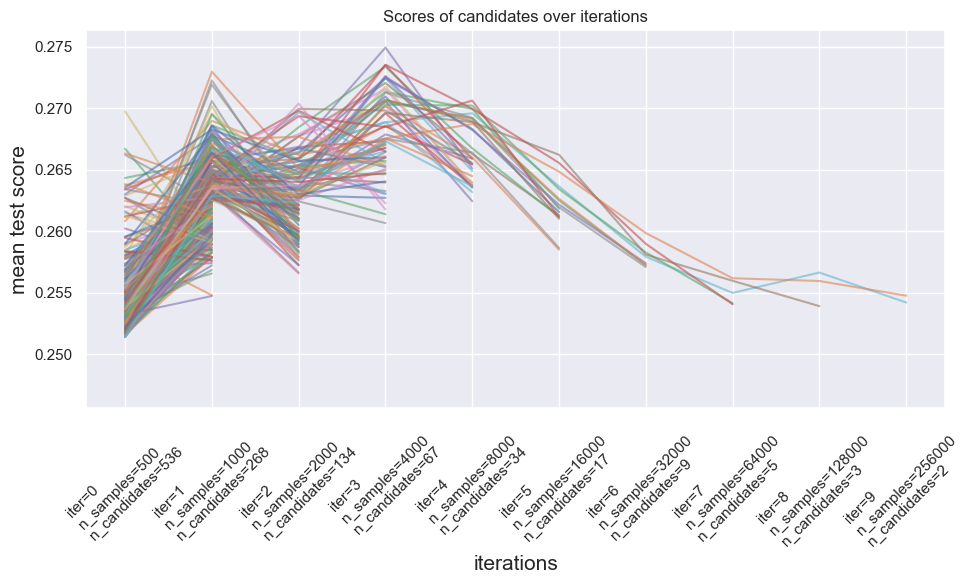

In [ ]:
# --- Cross-Validation Results ---
# Best Score (Accuracy): 0.2548

# Best Parameters Found:
#   colsample_bytree: 0.4829
#   learning_rate: 0.8398
#   max_depth: 3
#   reg_alpha: 0.7804
#   reg_lambda: 0.4580
#   scale_pos_weight: 2.1940
#   subsample: 0.4726


results = pd.DataFrame(halving_search.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={halving_search.n_resources_[i]}\nn_candidates={halving_search.n_candidates_[i]}"
    for i in range(halving_search.n_iterations_)
]

ax.set_xticks(range(halving_search.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.gcf().set_size_inches((10, 6))
plt.tight_layout()
plt.show()

Model trained.
Accuracy on training data: 0.7549219204438677
Accuracy on test data: 0.7169582772543741
For Model XGBoost: 
precision TRAIN: 0.516
% possible trades : 1.16
nb trade per day : 3.34
precision TEST: 0.322
% possible trades : 0.95
nb trade per day : 2.74


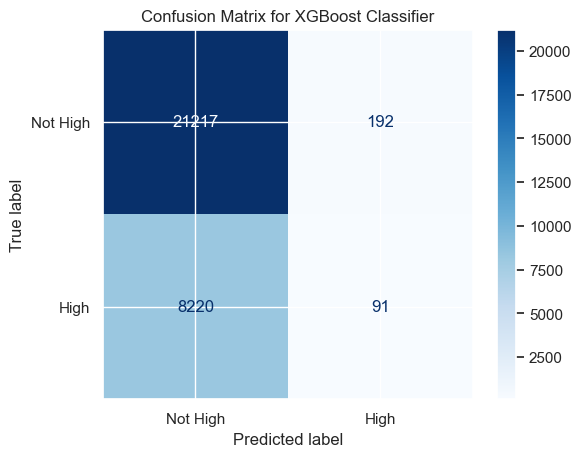

In [ ]:
print("Model trained.")
print("Accuracy on training data:", best_model.score(df_combined_condition, y_comb))
print("Accuracy on test data:", best_model.score(df_combined_condition_test, y_comb_test))
arr_xgb_pred_train = best_model.predict(df_combined_condition)
arr_xgb_pred = best_model.predict(df_combined_condition_test)
cm = confusion_matrix(y_comb_test, arr_xgb_pred, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost Classifier")

print("For Model XGBoost: ")
print(f"precision TRAIN: {precision_score(y_comb, arr_xgb_pred_train):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred_train) / arr_xgb_pred_train.shape[0]:.2f}")
print(f"nb trade per day : {288*arr_xgb_pred_train.sum() / arr_xgb_pred_train.shape[0]:.2f}")
print(f"precision TEST: {precision_score(y_comb_test, arr_xgb_pred):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred) / arr_xgb_pred.shape[0]:.2f}")
# per day
print(f"nb trade per day : {288*arr_xgb_pred.sum() / arr_xgb_pred.shape[0]:.2f}")
plt.show()

In [212]:
halving_search.best_params_

{'colsample_bytree': np.float64(0.4828742759599717),
 'learning_rate': np.float64(0.8397631202876449),
 'max_depth': 3,
 'reg_alpha': np.float64(0.7803761235709804),
 'reg_lambda': np.float64(0.4579957590035715),
 'scale_pos_weight': np.float64(2.1940158788635085),
 'subsample': np.float64(0.4726241559498734)}

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no pred

Model trained.
Accuracy on training data: 0.7549219204438677
Accuracy on test data: 0.7169582772543741
For Model XGBoost: 
precision TRAIN: 0.516
% possible trades : 1.16
nb trade per day : 3.34
precision TEST: 0.322
% possible trades : 0.95
nb trade per day : 2.74


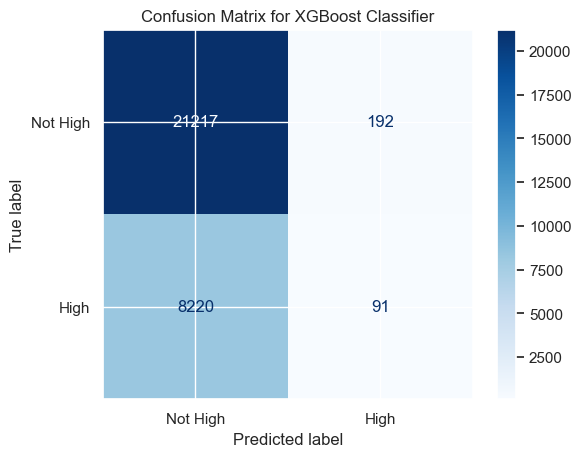

In [213]:
#   colsample_bytree: 0.4829
#   learning_rate: 0.8398
#   max_depth: 3
#   reg_alpha: 0.7804
#   reg_lambda: 0.4580
#   scale_pos_weight: 2.1940
#   subsample: 0.4726

# n 100 : 14.875
xgb_mdl = xgb.XGBClassifier(
    verbosity=0,
    objective="binary:hinge",
    random_state=42,
    n_jobs=-1,
    #use_label_encoder=False, # Recommended to avoid a future warning
    eval_metric=fun_trades_gain, #fun_trades_gain, #[fun_nb_trade_fixed_window, precision_score], #, # A common metric for binary classification
    max_depth=halving_search.best_params_["max_depth"],
    learning_rate=halving_search.best_params_["learning_rate"],
    subsample=halving_search.best_params_["subsample"],
    colsample_bytree=halving_search.best_params_["colsample_bytree"],
    reg_alpha=halving_search.best_params_["reg_alpha"],
    reg_lambda=halving_search.best_params_["reg_lambda"],
    #scale_pos_weight=1.5,  # ajuster si classes déséquilibrées
    n_estimators=200,#400+59+1,
)
xgb_mdl.fit(
    df_combined_condition, 
    y_comb, 
    eval_set=[(df_combined_condition_test, y_comb_test), (df_combined_condition, y_comb)],
    verbose=0,
)
#xgb_mdl.fit(df_combined_condition, y_comb)
print("Model trained.")
print("Accuracy on training data:", xgb_mdl.score(df_combined_condition, y_comb))
print("Accuracy on test data:", xgb_mdl.score(df_combined_condition_test, y_comb_test))
arr_xgb_pred_train = xgb_mdl.predict(df_combined_condition)
arr_xgb_pred = xgb_mdl.predict(df_combined_condition_test)
cm = confusion_matrix(y_comb_test, arr_xgb_pred, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost Classifier")

print("For Model XGBoost: ")
print(f"precision TRAIN: {precision_score(y_comb, arr_xgb_pred_train):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred_train) / arr_xgb_pred_train.shape[0]:.2f}")
print(f"nb trade per day : {288*arr_xgb_pred_train.sum() / arr_xgb_pred_train.shape[0]:.2f}")
print(f"precision TEST: {precision_score(y_comb_test, arr_xgb_pred):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred) / arr_xgb_pred.shape[0]:.2f}")
# per day
print(f"nb trade per day : {288*arr_xgb_pred.sum() / arr_xgb_pred.shape[0]:.2f}")
plt.show()

In [215]:
arr_eval = xgb_mdl.evals_result_["validation_0"]
arr_eval_train = xgb_mdl.evals_result_["validation_1"]

In [218]:
fun_plot_trades_gain(arr_eval, title_str="XBGBoost model performance on test set")

TypeError: fun_plot_trades_gain() missing 1 required positional argument: 'arr_eval_train'

### CV eval precision

In [ ]:
# --- Cross-Validation Results ---
# Best Score (Accuracy): 0.3672

# Best Parameters Found:
#   colsample_bytree: 0.6269
#   learning_rate: 0.1686
#   max_depth: 3
#   reg_alpha: 0.9613
#   reg_lambda: 0.4655
#   scale_pos_weight: 3.6372
#   subsample: 0.2046

# --- 3. Define the Base Model ---
# Note: 'n_estimators' is controlled by the search, so we don't set it here.
# 'early_stopping_rounds' is not used directly with HalvingRandomSearchCV.
xgb_mdl = xgb.XGBClassifier(
    objective="binary:hinge",
    random_state=42,
    #use_label_encoder=False, # Recommended to avoid a future warning
    eval_metric=fun_nb_trade_fixed_window, # A common metric for binary classification
    n_estimators=200,
)

# --- 4. Define the Hyperparameter Search Space ---
param_dist = {
    'max_depth': randint(1, 4),             # Search depths from 2 to 4
    'learning_rate': uniform(0.01, 1),   # Search from 0.05 up to 0.6
    'subsample': uniform(0.2, 0.9),         # Search between 0.4 and 0.9
    'colsample_bytree': uniform(0.1, 0.7),  # Search between 0.1 and 0.6
    'reg_alpha': uniform(0.0, 1),         # Search L1 regularization
    'reg_lambda': uniform(0.0, 1),        # Search L2 regularization
    'scale_pos_weight': uniform(1, 3),  # ajuster si classes déséquilibrées
}

tscv = TimeSeriesSplit(n_splits=5)

# --- 5. Set up and Run HalvingRandomSearchCV ---
halving_search_2 = HalvingRandomSearchCV(
    n_jobs=-1,                # Use all available CPU cores
    random_state=42,
    verbose=1,                # Set to 1 or 2 to see the progress
    cv=tscv,
    factor=2,  # Keep the top 1/3 of candidates in each iteration
    estimator=xgb_mdl,
    param_distributions=param_dist,
    #max_resources=150,        # The maximum n samples to use for the final model
    min_resources=500,         # The initial n_samples to start with
    scoring='precision',       # Metric for evaluation, since hinge loss gives 0/1
)

print("Starting HalvingRandomSearchCV...")
# Fit the model to the data
halving_search_2.fit(df_combined_condition, y_comb)
print("\nSearch complete!")

# --- 6. Display the Results ---
print("\n--- Cross-Validation Results ---")
print(f"Best Score (Accuracy): {halving_search_2.best_score_:.4f}")
print("\nBest Parameters Found:")
# Using a loop for cleaner printing
for param, value in halving_search_2.best_params_.items():
    if isinstance(value, float):
        print(f"  {param}: {value:.4f}")
    else:
        print(f"  {param}: {value}")

# The best_estimator_ is a fully trained model on the entire dataset
# using the best parameters found.
best_model_2 = halving_search_2.best_estimator_
print("\nBest model is now trained and ready to be used for predictions.")

Starting HalvingRandomSearchCV...
n_iterations: 10
n_required_iterations: 10
n_possible_iterations: 10
min_resources_: 500
max_resources_: 268188
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 536
n_resources: 500
Fitting 5 folds for each of 536 candidates, totalling 2680 fits


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:01:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:01:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:01:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:01:17] WARNING: /Users/runner/work/xgboost/xgboost/src

----------
iter: 1
n_candidates: 268
n_resources: 1000
Fitting 5 folds for each of 268 candidates, totalling 1340 fits


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:09:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:09:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:09:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:09:54] WARNING: /Users/runner/work/xgboost/xgboost/src

----------
iter: 2
n_candidates: 134
n_resources: 2000
Fitting 5 folds for each of 134 candidates, totalling 670 fits


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:15:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:15:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:15:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:15:13] WARNING: /Users/runner/work/xgboost/xgboost/src

----------
iter: 3
n_candidates: 67
n_resources: 4000
Fitting 5 folds for each of 67 candidates, totalling 335 fits


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:18:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:18:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:18:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:18:38] WARNING: /Users/runner/work/xgboost/xgboost/src

----------
iter: 4
n_candidates: 34
n_resources: 8000
Fitting 5 folds for each of 34 candidates, totalling 170 fits


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the test scores are non-finite: [0.21111111 0.12636364 0.13939394 ... 0.16060606 0.19166667 0.25952381]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the train scores are non-finite: [0.972      1.         1.         ... 0.57142857 0.7625     0.76666667]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:21:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:21:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used

----------
iter: 5
n_candidates: 17
n_resources: 16000
Fitting 5 folds for each of 17 candidates, totalling 85 fits


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the test scores are non-finite: [0.21111111 0.12636364 0.13939394 ... 0.33571429 0.10434783 0.08695652]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the train scores are non-finite: [0.972      1.         1.         ... 0.87485607 0.68505747 0.86208333]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:23:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:23:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used

----------
iter: 6
n_candidates: 9
n_resources: 32000
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the test scores are non-finite: [0.21111111 0.12636364 0.13939394 ... 0.29485289 0.31946775 0.30977958]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the train scores are non-finite: [0.972      1.         1.         ... 0.59604311 0.66217869 0.84099182]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:25:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:25:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used

----------
iter: 7
n_candidates: 5
n_resources: 64000
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the test scores are non-finite: [0.21111111 0.12636364 0.13939394 ... 0.34697079 0.19432234 0.31554894]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the train scores are non-finite: [0.972      1.         1.         ... 0.61582621 0.69207637 0.56394481]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:27:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:27:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used

----------
iter: 8
n_candidates: 3
n_resources: 128000
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the test scores are non-finite: [0.21111111 0.12636364 0.13939394 ... 0.30733437 0.33116571 0.3117797 ]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the train scores are non-finite: [0.972      1.         1.         ... 0.55104872 0.61838272 0.55092154]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:29:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:29:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used

----------
iter: 9
n_candidates: 2
n_resources: 256000
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the test scores are non-finite: [0.21111111 0.12636364 0.13939394 ... 0.33198384 0.34196781 0.3275684 ]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the train scores are non-finite: [0.972      1.         1.         ... 0.4928057  0.79732681 0.54252428]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:32:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:32:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used


Search complete!

--- Cross-Validation Results ---
Best Score (Accuracy): 0.3672

Best Parameters Found:
  colsample_bytree: 0.6269
  learning_rate: 0.1686
  max_depth: 3
  reg_alpha: 0.9613
  reg_lambda: 0.4655
  scale_pos_weight: 3.6372
  subsample: 0.2046

Best model is now trained and ready to be used for predictions.


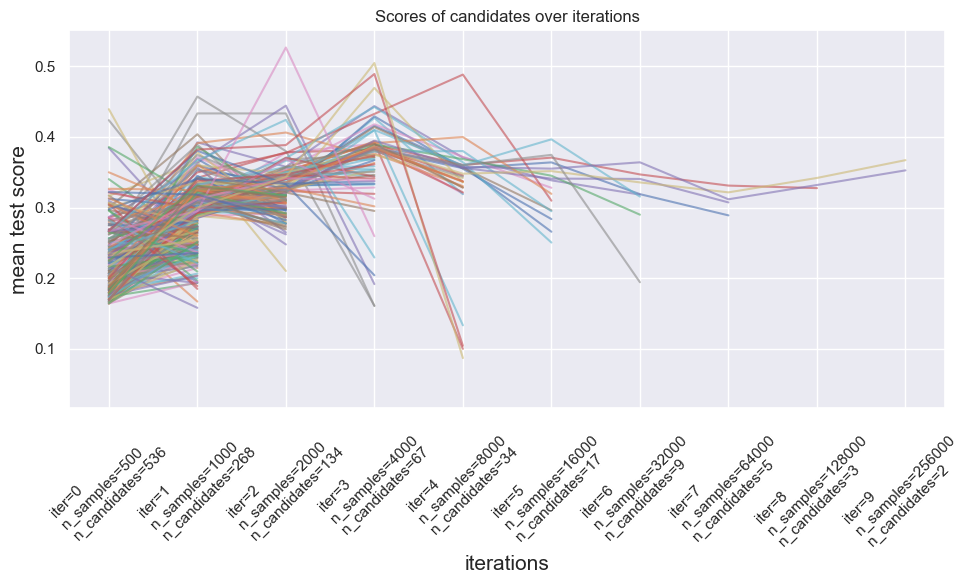

In [153]:
results = pd.DataFrame(halving_search_2.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={halving_search_2.n_resources_[i]}\nn_candidates={halving_search_2.n_candidates_[i]}"
    for i in range(halving_search_2.n_iterations_)
]

ax.set_xticks(range(halving_search_2.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.gcf().set_size_inches((10, 6))
plt.tight_layout()
plt.show()

Model trained.
Accuracy on training data: 0.7545937924142766
Accuracy on test data: 0.7203566621803499
For Model XGBoost: 
precision TRAIN: 0.800
% possible trades : 0.01
nb trade per day : 0.02
precision TEST: 0.000
% possible trades : 0.00
nb trade per day : 0.00


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



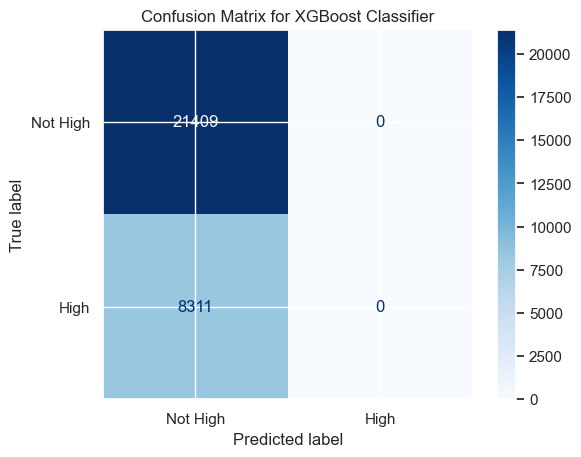

In [154]:
print("Model trained.")
print("Accuracy on training data:", best_model_2.score(df_combined_condition, y_comb))
print("Accuracy on test data:", best_model_2.score(df_combined_condition_test, y_comb_test))
arr_xgb_pred_train = best_model_2.predict(df_combined_condition)
arr_xgb_pred = best_model_2.predict(df_combined_condition_test)
cm = confusion_matrix(y_comb_test, arr_xgb_pred, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost Classifier")

print("For Model XGBoost: ")
print(f"precision TRAIN: {precision_score(y_comb, arr_xgb_pred_train):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred_train) / arr_xgb_pred_train.shape[0]:.2f}")
print(f"nb trade per day : {288*arr_xgb_pred_train.sum() / arr_xgb_pred_train.shape[0]:.2f}")
print(f"precision TEST: {precision_score(y_comb_test, arr_xgb_pred):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred) / arr_xgb_pred.shape[0]:.2f}")
# per day
print(f"nb trade per day : {288*arr_xgb_pred.sum() / arr_xgb_pred.shape[0]:.2f}")
plt.show()

In [155]:
results

iter  n_resources  mean_fit_time  std_fit_time  mean_score_time  \
0        0          500       4.078832      0.582533         0.312538   
1        0          500       4.076020      0.536661         0.306233   
2        0          500       2.571048      0.788137         0.360855   
3        0          500       1.740868      0.207088         0.386994   
4        0          500       0.653331      0.029737         0.000000   
...    ...          ...            ...           ...              ...   
1070     8       128000     101.611567     42.474607         1.685812   
1071     8       128000     103.702531     42.718367         1.700814   
1072     8       128000      91.071610     33.653149         1.551453   
1073     9       256000     171.059402     71.270643         2.479305   
1074     9       256000     173.181192     71.452991         2.538774   

      std_score_time  param_colsample_bytree  param_learning_rate  \
0           0.014016                0.362178             0.960714   
1           0.014835                0.421474             0.343709   
2           0.042175                0.227277             0.193405   
3           0.013488                0.197646             0.302145   
4           0.000000                0.514690             0.056450   
...              ...                     ...                  ...   
1070        0.417183                0.682981             0.916087   
1071        0.447168                0.626902             0.168605   
1072        0.504188                0.472322             0.799432   
1073        0.731429                0.682981             0.916087   
1074        0.764577                0.626902             0.168605   

      param_max_depth  param_reg_alpha  ...  std_test_score  rank_test_score  \
0                   3         0.779691  ...        0.193729              652   
1                   3         0.020584  ...        0.105564              911   
2                   2         0.524756  ...        0.170991              870   
3                   3         0.456070  ...        0.175546              879   
4                   3         0.680308  ...             NaN             1018   
...               ...              ...  ...             ...              ...   
1070                2         0.247510  ...        0.028251              186   
1071                3         0.961315  ...        0.053709              150   
1072                2         0.161363  ...        0.013679              203   
1073                2         0.247510  ...        0.027452              118   
1074                3         0.961315  ...        0.100628               81   

      split0_train_score split1_train_score  split2_train_score  \
0               1.000000           1.000000            1.000000   
1               1.000000           1.000000            1.000000   
2               1.000000           1.000000            1.000000   
3               1.000000           1.000000            1.000000   
4                    NaN                NaN                 NaN   
...                  ...                ...                 ...   
1070            0.607419           0.494888            0.538394   
1071            0.785714           0.788321            0.816817   
1072            0.664835           0.528139            0.478834   
1073            0.592456           0.461263            0.517274   
1074            0.807947           0.770130            0.834862   

      split3_train_score  split4_train_score  mean_train_score  \
0               0.900000            0.960000          0.972000   
1               1.000000            1.000000          1.000000   
2               1.000000            1.000000          1.000000   
3               1.000000            1.000000          1.000000   
4                    NaN                 NaN               NaN   
...                  ...                 ...               ...   
1070            0.424729            0.398599          0.492806   
1071  

### CV eval fun_trades_gain

In [193]:
from sklearn.metrics import make_scorer
fun_score_trades_gain = make_scorer(fun_trades_gain, greater_is_better=True)

In [ ]:
# {'colsample_bytree': np.float64(0.4633418536357893),
#  'learning_rate': np.float64(0.0776125635922149),
#  'max_depth': 1,
#  'reg_alpha': np.float64(0.06993160570943413),
#  'reg_lambda': np.float64(0.6401682238281661),
#  'subsample': np.float64(0.44403269285016633)}

# 'early_stopping_rounds' is not used directly with HalvingRandomSearchCV.
xgb_mdl = xgb.XGBClassifier(
    objective="binary:hinge",
    random_state=42,
    #use_label_encoder=False, # Recommended to avoid a future warning
    #eval_metric=fun_nb_trade_fixed_window, # A common metric for binary classification
    n_estimators=200,
)

# --- 4. Define the Hyperparameter Search Space ---
param_dist = {
    'max_depth': randint(1, 4),             # Search depths from 2 to 4
    'learning_rate': uniform(0.01, 1),   # Search from 0.05 up to 0.6
    'subsample': uniform(0.2, 0.9),         # Search between 0.4 and 0.9
    'colsample_bytree': uniform(0.1, 0.7),  # Search between 0.1 and 0.6
    'reg_alpha': uniform(0.0, 1),         # Search L1 regularization
    'reg_lambda': uniform(0.0, 1),        # Search L2 regularization
    #'scale_pos_weight': uniform(1, 3),  # ajuster si classes déséquilibrées
}

tscv = TimeSeriesSplit(n_splits=5)

# --- 5. Set up and Run HalvingRandomSearchCV ---
halving_search_2 = HalvingRandomSearchCV(
    n_jobs=-1,                # Use all available CPU cores
    random_state=42,
    verbose=1,                # Set to 1 or 2 to see the progress
    cv=tscv,
    factor=2,  # Keep the top 1/3 of candidates in each iteration
    estimator=xgb_mdl,
    param_distributions=param_dist,
    #max_resources=150,        # The maximum n samples to use for the final model
    min_resources=250,#500,         # The initial n_samples to start with
    scoring=fun_score_trades_gain,       # Metric for evaluation, since hinge loss gives 0/1
)

print("Starting HalvingRandomSearchCV...")
# Fit the model to the data
halving_search_2.fit(df_combined_condition, y_comb)
print("\nSearch complete!")

# --- 6. Display the Results ---
print("\n--- Cross-Validation Results ---")
print(f"Best Score (Accuracy): {halving_search_2.best_score_:.4f}")
print("\nBest Parameters Found:")
# Using a loop for cleaner printing
for param, value in halving_search_2.best_params_.items():
    if isinstance(value, float):
        print(f"  {param}: {value:.4f}")
    else:
        print(f"  {param}: {value}")

# The best_estimator_ is a fully trained model on the entire dataset
# using the best parameters found.
best_model_2 = halving_search_2.best_estimator_
print("\nBest model is now trained and ready to be used for predictions.")

Starting HalvingRandomSearchCV...
n_iterations: 11
n_required_iterations: 11
n_possible_iterations: 11
min_resources_: 250
max_resources_: 268188
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 1072
n_resources: 250
Fitting 5 folds for each of 1072 candidates, totalling 5360 fits


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

----------
iter: 1
n_candidates: 536
n_resources: 500
Fitting 5 folds for each of 536 candidates, totalling 2680 fits


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

----------
iter: 2
n_candidates: 268
n_resources: 1000
Fitting 5 folds for each of 268 candidates, totalling 1340 fits


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

----------
iter: 3
n_candidates: 134
n_resources: 2000
Fitting 5 folds for each of 134 candidates, totalling 670 fits


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

----------
iter: 4
n_candidates: 67
n_resources: 4000
Fitting 5 folds for each of 67 candidates, totalling 335 fits


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

----------
iter: 5
n_candidates: 34
n_resources: 8000
Fitting 5 folds for each of 34 candidates, totalling 170 fits


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the test scores are non-finite: [-260.625      -250.         -350.         ...  205.23015873   30.5
  -25.26190476]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the train scores are non-finite: [1783.5   1649.875 1783.5   ... 3486.    2556.    2506.   ]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and be

----------
iter: 6
n_candidates: 17
n_resources: 16000
Fitting 5 folds for each of 17 candidates, totalling 85 fits


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the test scores are non-finite: [-260.625      -250.         -350.         ...   46.29738562    3.01724138
   34.44444444]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the train scores are non-finite: [ 1783.5         1649.875       1783.5        ... 10860.12801932
  8334.90578285  3697.47368421]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMe

----------
iter: 7
n_candidates: 9
n_resources: 32000
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the test scores are non-finite: [-260.625      -250.         -350.         ...    0.         -548.08095238
    0.        ]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the train scores are non-finite: [1783.5   1649.875 1783.5   ...  134.5   3516.5    503.5  ]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined

----------
iter: 8
n_candidates: 5
n_resources: 64000
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the test scores are non-finite: [-260.625 -250.    -350.    ...    0.    -138.5    -50.   ]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the train scores are non-finite: [1783.5   1649.875 1783.5   ...    0.     626.5      0.   ]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no

----------
iter: 9
n_candidates: 3
n_resources: 128000
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the test scores are non-finite: [-260.625 -250.    -350.    ...    0.       0.       0.   ]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the train scores are non-finite: [1783.5   1649.875 1783.5   ...    0.       0.       0.   ]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no

----------
iter: 10
n_candidates: 2
n_resources: 256000
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital


Search complete!

--- Cross-Validation Results ---
Best Score (Accuracy): 0.0000

Best Parameters Found:
  colsample_bytree: 0.4633
  learning_rate: 0.0776
  max_depth: 1
  reg_alpha: 0.0699
  reg_lambda: 0.6402
  subsample: 0.4440

Best model is now trained and ready to be used for predictions.


In [197]:
halving_search_2.best_params_

{'colsample_bytree': np.float64(0.4633418536357893),
 'learning_rate': np.float64(0.0776125635922149),
 'max_depth': 1,
 'reg_alpha': np.float64(0.06993160570943413),
 'reg_lambda': np.float64(0.6401682238281661),
 'subsample': np.float64(0.44403269285016633)}

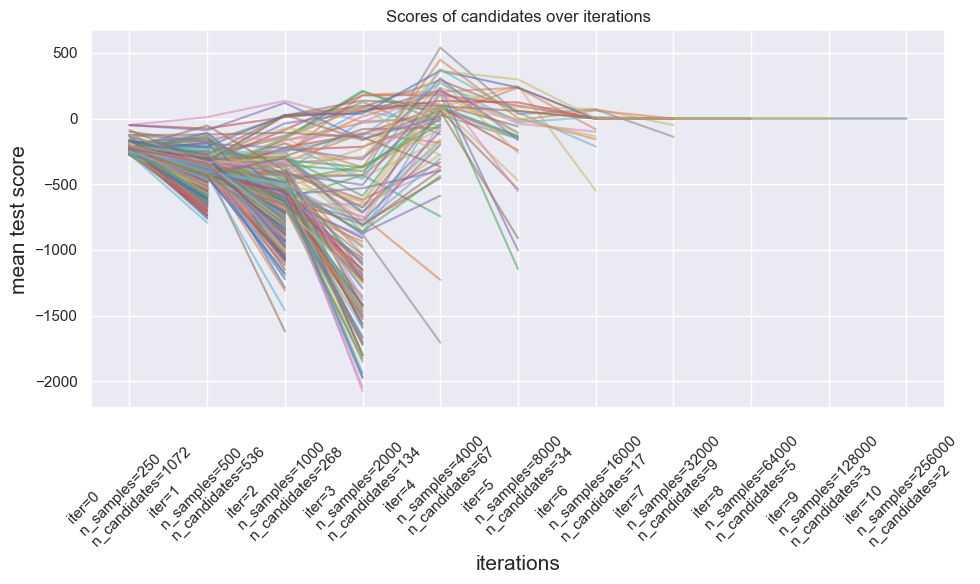

In [ ]:
# --- Cross-Validation Results ---
# Best Score (Accuracy): 0.0000

# Best Parameters Found:
#   colsample_bytree: 0.4633
#   learning_rate: 0.0776
#   max_depth: 1
#   reg_alpha: 0.0699
#   reg_lambda: 0.6402
#   subsample: 0.4440

results = pd.DataFrame(halving_search_2.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={halving_search_2.n_resources_[i]}\nn_candidates={halving_search_2.n_candidates_[i]}"
    for i in range(halving_search_2.n_iterations_)
]

ax.set_xticks(range(halving_search_2.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.gcf().set_size_inches((10, 6))
plt.tight_layout()
plt.show()

In [199]:
results

iter  n_resources  mean_fit_time  std_fit_time  mean_score_time  \
0        0          250       3.346789      0.318163         0.345514   
1        0          250       3.385190      0.309031         0.351072   
2        0          250       2.385303      0.554273         0.357013   
3        0          250       1.716423      0.124175         0.404573   
4        0          250       1.715342      0.143474         0.426532   
...    ...          ...            ...           ...              ...   
2142     9       128000     100.397790     41.336137         1.633764   
2143     9       128000     101.744923     40.781728         1.731463   
2144     9       128000      89.931747     32.735682         1.602549   
2145    10       256000     166.614218     69.612427         2.503168   
2146    10       256000     165.978558     68.910778         2.505209   

      std_score_time  param_colsample_bytree  param_learning_rate  \
0           0.031545                0.362178             0.960714   
1           0.027922                0.169982             0.469249   
2           0.031498                0.778937             0.842443   
3           0.021304                0.528157             0.017066   
4           0.053853                0.304501             0.376362   
...              ...                     ...                  ...   
2142        0.380881                0.750041             0.071808   
2143        0.455392                0.463342             0.077613   
2144        0.531120                0.377758             0.054388   
2145        0.785377                0.463342             0.077613   
2146        0.814164                0.377758             0.054388   

      param_max_depth  param_reg_alpha  ...  std_test_score  rank_test_score  \
0                   3         0.779691  ...      392.769812              685   
1                   1         0.601115  ...      387.298335              595   
2                   2         0.000779  ...      374.165739             1194   
3                   1         0.291229  ...      100.000000              117   
4                   2         0.090606  ...      390.344008              335   
...               ...              ...  ...             ...              ...   
2142                1         0.239989  ...        0.000000               78   
2143                1         0.069932  ...        0.000000               78   
2144                1         0.397015  ...        0.000000               78   
2145                1         0.069932  ...        0.000000               78   
2146                1         0.397015  ...        0.000000               78   

     split0_train_score  split1_train_score  split2_train_score  \
0                 307.5               615.0            1845.000   
1                 307.5               615.0            1426.875   
2                 307.5               615.0            1845.000   
3                  -0.0                -0.0             338.000   
4                 307.5               615.0            1845.000   
...                 ...                 ...                 ...   
2142               -0.0                -0.0              -0.000   
2143               -0.0                -0.0              -0.000   
2144               -0.0                -0.0              -0.000   
2145               -0.0                -0.0              -0.000   
2146               -0.0                -0.0              -0.000   

      split3_train_score  split4_train_score  mean_train_score  \
0                 2460.0              3690.0          1783.500   
1                 2210.0              3690.0          1649.875   
2                 2460.0              3690.0          1783.500   
3                  615.0               922.5           375.100   
4                 2460.0              3690.0          1783.500   
...                  ...                 ...               ...   
2142                -0.0                -0.0             0.000   
2143  

In [200]:
results.columns

Index(['iter', 'n_resources', 'mean_fit_time', 'std_fit_time',
       'mean_score_time', 'std_score_time', 'param_colsample_bytree',
       'param_learning_rate', 'param_max_depth', 'param_reg_alpha',
       'param_reg_lambda', 'param_subsample', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score', 'params_str'],
      dtype='object')

In [211]:
list(results[results["iter"]==0].param_max_depth.unique())

[np.int64(3), np.int64(1), np.int64(2)]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no pred

Model trained.
Accuracy on training data: 0.7545565051381866
Accuracy on test data: 0.7203566621803499
For Model XGBoost: 
precision TRAIN: 0.625
% possible trades : 0.00
nb trade per day : 0.01
precision TEST: 0.000
% possible trades : 0.00
nb trade per day : 0.00


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



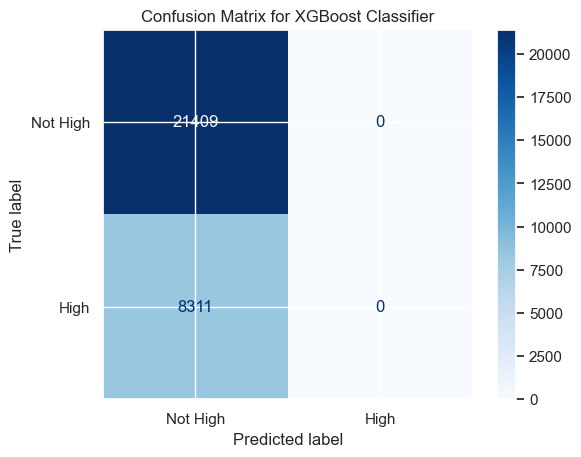

In [222]:
# n 100 : 14.875
xgb_mdl = xgb.XGBClassifier(
    verbosity=0,
    objective="binary:hinge",
    random_state=42,
    n_jobs=-1,
    #use_label_encoder=False, # Recommended to avoid a future warning
    eval_metric=fun_trades_gain, #fun_trades_gain, #[fun_nb_trade_fixed_window, precision_score], #, # A common metric for binary classification
    max_depth=halving_search_2.best_params_["max_depth"],
    learning_rate=halving_search_2.best_params_["learning_rate"],
    subsample=halving_search_2.best_params_["subsample"],
    colsample_bytree=halving_search_2.best_params_["colsample_bytree"],
    reg_alpha=halving_search_2.best_params_["reg_alpha"],
    reg_lambda=halving_search_2.best_params_["reg_lambda"],
    #scale_pos_weight=1.5,  # ajuster si classes déséquilibrées
    n_estimators=2000,#400+59+1,
)
xgb_mdl.fit(
    df_combined_condition, 
    y_comb, 
    eval_set=[(df_combined_condition_test, y_comb_test), (df_combined_condition, y_comb)],
    verbose=0,
)
#xgb_mdl.fit(df_combined_condition, y_comb)
print("Model trained.")
print("Accuracy on training data:", xgb_mdl.score(df_combined_condition, y_comb))
print("Accuracy on test data:", xgb_mdl.score(df_combined_condition_test, y_comb_test))
arr_xgb_pred_train = xgb_mdl.predict(df_combined_condition)
arr_xgb_pred = xgb_mdl.predict(df_combined_condition_test)
cm = confusion_matrix(y_comb_test, arr_xgb_pred, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost Classifier")

print("For Model XGBoost: ")
print(f"precision TRAIN: {precision_score(y_comb, arr_xgb_pred_train):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred_train) / arr_xgb_pred_train.shape[0]:.2f}")
print(f"nb trade per day : {288*arr_xgb_pred_train.sum() / arr_xgb_pred_train.shape[0]:.2f}")
print(f"precision TEST: {precision_score(y_comb_test, arr_xgb_pred):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred) / arr_xgb_pred.shape[0]:.2f}")
# per day
print(f"nb trade per day : {288*arr_xgb_pred.sum() / arr_xgb_pred.shape[0]:.2f}")
plt.show()

In [223]:
arr_eval = xgb_mdl.evals_result_["validation_0"]
arr_eval_train = xgb_mdl.evals_result_["validation_1"]

In [224]:
fun_plot_trades_gain(arr_eval, arr_eval_train)